# Advanced Functionality

In [1]:
import placekey as pk
import geopandas as gpd
import numpy as np
import folium

## Approximating regions with Placekeys

We've included a data file that contains Census block group (CBG) geometries for California. The original file and more are available from the [Census website](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html).

In [2]:
cbgs = gpd.read_file('../data/CA_2019_census_block_groups_sample/').set_index('GEOID')
cbgs.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
GEOID,,,,,,,,,,,,
060750122012,06,075,012201,2,Block Group 2,G5030,S,30528,0,+37.7849116,-122.4161659,"POLYGON ((-122.41790 37.78517, -122.41626 37.7..."
060750124012,06,075,012401,2,Block Group 2,G5030,S,45978,0,+37.7831562,-122.4149685,"POLYGON ((-122.41607 37.78445, -122.41478 37.7..."
060750124023,06,075,012402,3,Block Group 3,G5030,S,62826,0,+37.7830940,-122.4192115,"POLYGON ((-122.42107 37.78382, -122.42093 37.7..."
060750126021,06,075,012602,1,Block Group 1,G5030,S,248192,544217,+37.8064743,-122.4356584,"POLYGON ((-122.44308 37.80973, -122.43008 37.8..."
060750129011,06,075,012901,1,Block Group 1,G5030,S,90524,0,+37.8010280,-122.4270595,"POLYGON ((-122.42967 37.80165, -122.42802 37.8..."


 The row with `GEOID == 060750124022` corresponds to the CBG that contains San Francisco City Hall, which is the one we want to approximate. GeoPandas stores the geometry of the CBGs in the `geometry` column as Shapely Polygons.

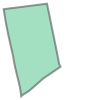

In [3]:
cbg_geometry = cbgs.loc['060750124022']['geometry']
cbg_geometry

It's nice that Shapely draws the polygon for us, but let's see what it looks like on a map.

In [4]:
cbg_centroid = next(zip(*cbg_geometry.centroid.xy))  # This is a (long, lat) tuple
cbg_map = folium.Map(cbg_centroid[::-1], zoom_start=16, tiles='cartodbpositron')
folium.GeoJson(cbg_geometry).add_to(cbg_map)
cbg_map

The function `polygon_to_placekeys()` generates the set of Placekeys which cover a given polygon. This set is split into two disjoint subsets:

* **interior**: Placekeys with 100% of their area contained in the polygon,
* **boundary**: Placekeys with more than 0% but less tahn 100% of their area contained in the polygon.
    
There is an optional parameter for this function, `include_touching`, which when `True` will include Placekeys that intersect the polygon, but have 0% of their area contained in the polygon (e.g. they only share boundary points). In case you are working with polygons specified by WKTs or GeoJSONs, there are equivalent functions for those input types (`wkt_to_placekeys()` and `geojson_to_placekeys()`).

In [5]:
covering_placekeys = pk.polygon_to_placekeys(cbg_geometry, geo_json=True)
covering_placekeys

{'interior': ('@5vg-7gq-tvz',
  '@5vg-7gq-tjv',
  '@5vg-7gq-v2k',
  '@5vg-7gq-tsq',
  '@5vg-7gq-7t9'),
 'boundary': ('@5vg-7gq-t7q',
  '@5vg-7gq-7wk',
  '@5vg-7gq-7kf',
  '@5vg-7gq-r8v',
  '@5vg-7gq-tn5',
  '@5vg-7gq-qpv',
  '@5vg-7gq-ty9',
  '@5vg-7gq-t9z',
  '@5vg-7gq-syv',
  '@5vg-7gq-7yv',
  '@5vg-7gq-rff',
  '@5vg-7gq-tqf',
  '@5vg-7gq-dn5',
  '@5vg-7gq-d9z',
  '@5vg-7gq-gx5',
  '@5vg-7gq-7nq',
  '@5vg-7gq-7qz')}

Before we continue, here's a function for plotting Placekeys. It can be used on its own, or passed another Folium map to add the Placekeys to.

In [6]:
def draw_placekeys(placekey_values, zoom_start=18, folium_map=None, hex_color='lightblue', weight=2, labels=False):
    """
    :param placekey_values: A list of Placekey strings
    :param zoom_start: Folium zoom level. 18 is suitable for neighboring resolution 10 H3s.
    :folium_map: A Folium map object to add the Placekeys to
    :labels: Whether or not to add labels for Placekeys
    :return: a Folium map object
    
    """
    geos = [pk.placekey_to_geo(p) for p in placekey_values]
    hexagons = [pk.placekey_to_hex_boundary(p) for p in placekey_values]

    if folium_map is None:
        centroid = np.mean(geos, axis=0)
        folium_map = folium.Map((centroid[0], centroid[1]), zoom_start=zoom_start, tiles='cartodbpositron')

    for h in hexagons:
        folium.Polygon(
            locations=h,
            weight=weight,
            color=hex_color
        ).add_to(folium_map)
        
    if labels:
        for p, g in zip(placekey_values, geos):
            icon = folium.features.DivIcon(
                icon_size=(120, 36),
                icon_anchor=(60, 15),
                html='<div style="align: center; font-size: 12pt; background-color: lightblue; border-radius: 5px; padding: 2px">{}</div>'.format(p),
            )
            
            folium.map.Marker(
                [g[0], g[1]],
                icon=icon
            ).add_to(folium_map)
        
    return folium_map

In [7]:
pk_cbg_map = draw_placekeys(covering_placekeys['boundary'], folium_map=cbg_map, hex_color='orange')
pk_cbg_map = draw_placekeys(covering_placekeys['interior'], folium_map=pk_cbg_map, hex_color='red')

pk_cbg_map

## Proximity of Placekeys

Similar Placekeys are physically close to each other, and often physically close places will have similar Placekeys (this won't always be true since we're trying to cover the earth with a linear ordering of codes). Below is our earlier example with Placekeys labelled by their Where part.

In [8]:
draw_placekeys(
    covering_placekeys['interior'] + covering_placekeys['boundary'],
    zoom_start=17, labels=True
)

We provide a function for explicitly computing the distance in meters between two Placekeys based on the centers of the Where parts.

In [9]:
pk.placekey_distance('@5vg-7gq-dn5', '@5vg-7gq-t9z')

473.56101045983115

The library also contains a table of the maximal distance in meters between two Placekeys based on the length of their common prefix.

In [10]:
pk.get_prefix_distance_dict()

{0: 20040000.0,
 1: 20040000.0,
 2: 2777000.0,
 3: 1065000.0,
 4: 152400.0,
 5: 21770.0,
 6: 8227.0,
 7: 1176.0,
 8: 444.3,
 9: 63.47}

## Outputing Placekeys to geometry formats

In case of a need to either visualize Placekeys or to serialize their shape in a data file, the Placekey library has several output options for the geometry of a Placekey. The Placekey library by default
1. represents points as (latitudue, longitude)
2. orients the boundaries of polygons counter-clockwise

The GeoJSON format represents points as (longitude, latitude), so all output functions have a parameter `geo_json` which when `True` will cause points to be output in this format. Setting this flag will also cause list of boundary points to have the first and last entry the same. Functions with `geojson` in their name have `geo_json=True` by default, while other functions have `geo_json=False` by default. This difference is easy to spot with `placekey_to_hex_boundary()`.

In [11]:
pk.placekey_to_hex_boundary('@5vg-7gq-tjv')

((37.77921928451977, -122.41844077039543),
 (37.77972548542876, -122.41780166521563),
 (37.78039571852498, -122.41800851332172),
 (37.780559746916104, -122.41885447351558),
 (37.78005354361958, -122.41949357434298),
 (37.77938331431949, -122.41928671932915))

In [12]:
pk.placekey_to_hex_boundary('@5vg-7gq-tjv', geo_json=True)

((-122.41844077039543, 37.77921928451977),
 (-122.41780166521563, 37.77972548542876),
 (-122.41800851332172, 37.78039571852498),
 (-122.41885447351558, 37.780559746916104),
 (-122.41949357434298, 37.78005354361958),
 (-122.41928671932915, 37.77938331431949),
 (-122.41844077039543, 37.77921928451977))

Placekeys can also be output to [Shapely](https://shapely.readthedocs.io/en/latest/project.html) polygons, [WKT (Well-Known Text)](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry), and [GeoJSON](https://geojson.org/) dictionaries.

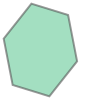

In [13]:
pk.placekey_to_polygon('@5vg-7gq-tjv')

In [14]:
pk.placekey_to_wkt('@5vg-7gq-tjv')

'POLYGON ((37.77921928451977 -122.4184407703954, 37.77938331431949 -122.4192867193292, 37.78005354361958 -122.419493574343, 37.7805597469161 -122.4188544735156, 37.78039571852498 -122.4180085133217, 37.77972548542876 -122.4178016652156, 37.77921928451977 -122.4184407703954))'

In [15]:
pk.placekey_to_geojson('@5vg-7gq-tjv')

{'type': 'Polygon',
 'coordinates': (((-122.41844077039543, 37.77921928451977),
   (-122.41780166521563, 37.77972548542876),
   (-122.41800851332172, 37.78039571852498),
   (-122.41885447351558, 37.780559746916104),
   (-122.41949357434298, 37.78005354361958),
   (-122.41928671932915, 37.77938331431949),
   (-122.41844077039543, 37.77921928451977)),)}

## Validating Placekeys

The Plackey library can validate the format of Placekeys and the Where part (e.g. "@5vg-7gq-tjv"). Validation of the What part (e.g. "223-227@") can be done via the [Placekey service API](https://docs.placekey.io/).

In [16]:
pk.placekey_format_is_valid("223-227@5vg-7gq-tjv")

True

In [17]:
pk.placekey_format_is_valid("223-227@ima-bad-key")

False